In [1]:
import zipfile


zip_ref = zipfile.ZipFile("/content/drive/My Drive/test.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()

In [3]:
import shutil
import os
import numpy as np
import json
import pandas as pd
import pprint
import time
import cv2
import matplotlib.pyplot as plt
import scipy.misc
from skimage.io import imread, imshow, imread_collection, concatenate_images
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from keras.initializers import glorot_uniform
from keras import backend as K
K.clear_session()


In [4]:

def compute_mean_iou(y_true, y_pred, smooth=1):

    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def compute_mean_diec(y_true, y_pred, smooth=1):

    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

In [5]:
with open('/content/drive/My Drive/label_txt.txt') as f:
    label_to_color_map = json.load(f)

In [6]:
def load_image(path):
    image = cv2.imread(path,-1)
    return image
    
def image_array(path,height,width):
  img=np.expand_dims(np.float32(load_image(path)[:height, :width]),axis=0)/255.0
  return img

def one_hot_it(path,height,width, label_values):

    label=load_image(path)[:height, :width]
    semantic_map = []

    for key in list(label_to_color_map.keys()):
        colour = label_to_color_map[key]
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
        
    semantic_map = np.stack(semantic_map, axis=-1)
    # print("Time 2 = ", time.time() - st)

    return semantic_map

In [7]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, input_image,input_height,input_width,label_values, batch_size,shuffle=True):
        'Initialization'
        
        self.batch_size = batch_size

        self.input_image = input_image
        self.input_height=input_height
        self.input_width=input_width
        self.label_values=label_values
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.input_image) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        self.list_IDs_temp_y = [self.input_image[k] for k in indexes]
        self.list_IDs_temp_x = [p.replace('/content/drive/My Drive/datasets_all/output', '/content') for p in self.list_IDs_temp_y]

        # Generate data
        X, Y = self.__data_generation(self.list_IDs_temp_x,self.list_IDs_temp_y)
        X=np.squeeze(X, axis = 1) 
        return X, Y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.input_image))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, in_X,in_Y):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        return_X=[]
        return_Y=[]
        # Generate data
        for X_Image,Y_Image in  zip(in_X,in_Y):
            # Store sample
            return_X.append(image_array(X_Image,self.input_height,self.input_width))
            return_Y.append(np.array(one_hot_it(Y_Image,self.input_height, self.input_width, self.label_values), dtype=np.uint8))

        return np.array(return_X), np.array(return_Y)

In [8]:
from glob import glob

test_image_y = glob('/content/drive/My Drive/datasets_all/output/test/*_leftImg8bit.png')

In [10]:
test_generator = DataGenerator(test_image_y,600,720,' ', batch_size=6,shuffle=True)

In [18]:
from keras.models import Model, load_model
from keras import backend as K
K.clear_session()

dependencies = {'compute_mean_iou': compute_mean_iou,'compute_mean_diec':compute_mean_diec}
model = load_model('/content/drive/My Drive/weights-improvement.rescan_wts (4).hdf5',custom_objects = dependencies)
hist = model.evaluate(test_generator,verbose = 0)
  

In [19]:
#Evaluation metrics on test data
print("Mean IoU is "+ str(hist[1]))
print("Dice Coefficient is "+ str(hist[2]))
print("accuracy is "+ str(hist[3]))

Mean IoU is 0.5150415897369385
Dice Coefficient is 0.6629474759101868
accuracy is 0.7408295273780823


In [20]:
XX=image_array('/content/001133_leftImg8bit.png',600,720)
hist = model.predict(XX)

In [21]:
def reverse_one_hot(image):

    x = np.argmax(image, axis = -1)
    return x

In [22]:
hist_tt=reverse_one_hot(hist)

hist_mm=np.squeeze(hist_tt, axis = 0) 
hist_mm.shape

(600, 720)

In [23]:
label_values=[]
for key in list(label_to_color_map.keys()):
  label_values.append(label_to_color_map[key])

In [24]:
def colour_code_segmentation(image, label_values):
    
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [34]:
img=colour_code_segmentation(hist_mm, label_values)

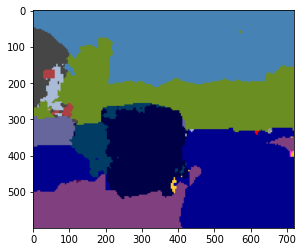

In [43]:
import matplotlib.pyplot as plt
import imageio

plt.imshow(img)
imageio.imwrite('pic.png', img)
plt.show()

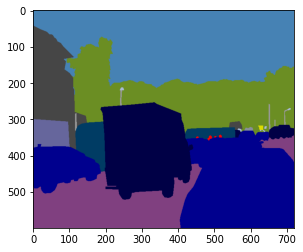

In [44]:
YY=image_array('/content/drive/My Drive/datasets_all/output/train/001133_leftImg8bit.png',600,720)
plt.imshow(np.squeeze(YY, axis = 0) )
imageio.imwrite('2pic.png', np.squeeze(YY, axis = 0) )
plt.show()

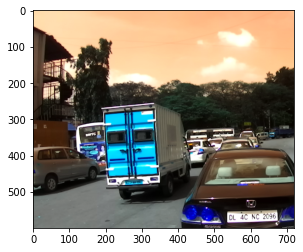

In [45]:
YY=image_array('/content/001133_leftImg8bit.png',600,720)
plt.imshow(np.squeeze(YY, axis = 0) )
imageio.imwrite('2pic.png', np.squeeze(YY, axis = 0) )
plt.show()